## "Gold Panning but for Transients" - ZTF Summer School Day 2

Hey folks! Now that you've been introduced to alert streams through ZTF and looked at already selected candidates on SkyPortal, let's go back upstream and see how **YOU** can look at the entire ZTF alert stream and find what you're interested in.

<img src="https://upload.wikimedia.org/wikipedia/commons/8/84/Gold_panning_at_Bonanza_Creek.JPG" width="900px">

I like to compare it to [gold panning](https://en.wikipedia.org/wiki/Gold_panning), where you have a lot of material to sift through, and you iteratively filter it down to the interesting stuff, and most of the time you don't find anything. Let's remain hopeful, though, and see what we can find!

### Let's start by answering some questions:
#### What is the ZTF alert stream?
We talked about it yesterday, but let's recap. The ZTF alert stream is a continuous stream of astronomical data that comes from the ZTF survey, a wide-field survey that scans the sky for transient events. Every time a new observation is made, we compare that new image with a "reference image" (a stack of previous observations over multiple years, giving us some kind of average of what the sky looks like) and if we find something that is different, we generate an alert. This alert contains information about the current detection, such as its position, brightness, and other properties. It also contains time-series photometry, which is the brightness of the object over time if we had previous detections at the same location. Last but not least, we have the new, reference, and subtraction (new - ref using an image subtraction algorithm) images, which are the images that were used to generate the alert.

#### What can we do with it?
Because the stream isn't designed to look for a specific type of object, you can use it to find any type of transient event you are interested in. For example, you can look for supernovae, variable stars, or even gravitational wave counterparts.

#### How do we access it?
There are a number of public and private alert brokers for ZTF, but today we'll look at **BOOM**. **BOOM** is currently being developed, with the goal of serving as a multi-survey alert broker. This means that it won't just have ZTF data, but it will have LSST, DECAM, ... and any other survey we can get our hands on. Also, it won't just process these streams on their own but instead will keep crossmatching them together, and provide the users with the tools required to use the data from multiple surveys at once. This means more datapoints and multi-wavelength data for the same object, which is great for classification and understanding the nature of the transient event.
*Just for the summer school, we've setup a public instance of **SkyPortal** and **BOOM** that you can use to access the ZTF alert stream. It is hosted at https://boomdemo.caltech.edu, serving an HTTP API which is documented [here](https://boomdemo.caltech.edu/docs).*

---
First, let's start with some imports:

In [1]:
import gzip
import io
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import requests
from astropy.io import fits
from astropy.visualization import (
    AsymmetricPercentileInterval,
    ImageNormalize,
    LinearStretch,
    LogStretch,
)
from tqdm import tqdm

---
Next, let's define 2 methods we'll re-use here and there to visualize the data we get from the broker. The first one is a method to cutout images of a given alert, and the second one is a method to plot the light curve of a given object.

*Note: You don't need to worry too much about these. Feel free to edit them as needed, or ignoring them if you want to focus on data exploration.*

In [2]:
thumbnail_types = [
    ("cutoutScience", "new"),
    ("cutoutTemplate", "ref"),
    ("cutoutDifference", "sub"),
]

# this plots the 3 cutouts for a given object (new, reference, and subtraction)
def plot_cutouts(obj_id, cutouts, survey="ZTF"):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(f"Cutouts for {obj_id} ({survey})", fontsize=16)

    for ax, (cutout_type, thumbnail_type) in zip(axs, thumbnail_types):
        cutout_data = cutouts.get(cutout_type)
        # cutout_data can be a gzipped FITS file served as a string
        # or a bytes array. If its a bytes array, convert to a string again
        if isinstance(cutout_data, list):
            cutout_data = bytes(cutout_data)
        if cutout_data:
            with gzip.open(io.BytesIO(cutout_data), "rb") as f:
                with fits.open(io.BytesIO(f.read()), ignore_missing_simple=True) as hdu:
                    image_data = hdu[0].data

            if survey == "ZTF":
                # Survey-specific transformations to get North up and West on the right
                image_data = np.flipud(image_data)

            # replace nans with median:
            img = np.array(image_data)
            # replace dubiously large values
            xl = np.greater(np.abs(img), 1e20, where=~np.isnan(img))
            if img[xl].any():
                img[xl] = np.nan
            if np.isnan(img).any():
                median = float(np.nanmean(img.flatten()))
                img = np.nan_to_num(img, nan=median)

            norm = ImageNormalize(
                img,
                stretch=LinearStretch()
                if cutout_type == "cutoutDifference"
                else LogStretch(),
            )
            img_norm = norm(img)
            normalizer = AsymmetricPercentileInterval(
                lower_percentile=1, upper_percentile=100
            )
            vmin, vmax = normalizer.get_limits(img_norm)
            ax.imshow(img_norm, cmap="bone", origin="lower", vmin=vmin, vmax=vmax)
            ax.set_title(thumbnail_type)
        else:
            ax.text(0.5, 0.5, f"No {thumbnail_type} cutout", ha='center', va='center')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [3]:
band2color = {"g": "green", "r": "red", "i": "yellow"}

# plot light curve of a given object (detections only)
def plot_light_curve(data, magfield='magpsf', sigfield='sigmapsf', diffmaglim_field='diffmaglim', obj_id=None):
    if not data:
        print("No data to plot.")
        return
    
    # split detections and non detections
    jds = np.array([d['jd'] for d in data])
    magpsf = np.array([d.get(magfield, np.nan) for d in data])
    sigmapsf = np.array([d.get(sigfield, np.nan) for d in data])
    bands = np.array([d['band'] for d in data])

    mask_detections = np.isfinite(magpsf) & np.isfinite(sigmapsf)
    
    for b in ["r", "g", "i"]:
        mask_band = bands == b
        mask_detected = mask_detections & mask_band
        plt.errorbar(
            jds[mask_detected],
            magpsf[mask_detected],
            yerr=sigmapsf[mask_detected],
            fmt='o',
            label=f'{b} band',
            color=band2color[b],
            alpha=0.7
        )
    plt.gca().invert_yaxis()  # Invert y-axis for magnitude
    plt.xlabel('JD')
    plt.ylabel('Magnitude')
    plt.title(obj_id if obj_id else 'Light Curve')
    plt.legend()
    plt.grid()
    plt.show()

---
Last step before we start exploring the data: We define an API client class so we can abstract away the HTTP requests and responses later on, again in an effort to make the code cleaner and easier to read. This class will handle the authentication, the requests, and the responses, and will provide us with methods to interact with the API.

*Note: You could easily extend this class to add custom methods for specific endpoints and parameters, to make things even easier to use.*

In [4]:
class BoomAPI:
    def __init__(self, protocol='https', host='boomdemo.caltech.edu', port=443, username=None, password=None):
        self.base_url = f"{protocol}://{host}:{port}"
        self.session = requests.Session()
        self.expires_at = None  # Placeholder for token expiration time
        # we use JWT for authentication
        self.session.headers.update({'Content-Type': 'application/json'})
        if username and password:
            if not self.authenticate(username, password):
                raise Exception("Authentication failed. Please check your credentials.")

    def authenticate(self, username, password):
        """Authenticate with the Boom API and store the JWT token."""
        response = self.session.post(f"{self.base_url}/auth", json={'username': username, 'password': password})
        if response.status_code == 200:
            data = response.json()
            token_type = data.get('token_type', 'Bearer')
            expires_at = data.get('expires_at')
            if expires_at:
                self.expires_at = datetime.fromtimestamp(expires_at)
            self.session.headers.update({'Authorization': f"{token_type} {data['access_token']}"})
            return True
        else:
            print("Authentication failed:", response.text)
            return False

    def api(self, method, endpoint, **kwargs):
        """Make an API request."""
        if self.expires_at and datetime.now() >= self.expires_at:
            print("Token expired, re-authenticating...")
            if not self.authenticate(self.session.headers.get('username'), self.session.headers.get('password')):
                raise Exception("Re-authentication failed.")
        url = f"{self.base_url}{endpoint}"
        response = self.session.request(method, url, **kwargs)
        if response.status_code in [200, 201]:
            return response.json()
        else:
            print(f"Error {response.status_code}: {response.text}")
            return None

    def find(self, catalog, query, projection=None, **kwargs):
        """Find objects in a catalog with a query."""
        if not catalog:
            raise ValueError("Catalog name must be provided.")
        if not query:
            raise ValueError("Query must be provided.")
        params = {'catalog_name': catalog, 'filter': query}
        if projection:
            params['projection'] = projection
        params = {**kwargs, **params}
        response = self.api('POST', f"/queries/find", json=params)
        if response and 'data' in response:
            return response['data']
        return None

    def count(self, catalog, query, **kwargs):
        """Count objects in a catalog with a query."""
        if not catalog:
            raise ValueError("Catalog name must be provided.")
        params = {'catalog_name': catalog, 'filter': query if query else {}}
        params = {**kwargs, **params}
        response = self.api('POST', f"/queries/count", json=params)
        if response and 'data' in response:
            return response['data']
        return None


In [6]:
api = BoomAPI(username='ztfsummerschool25', password='ZTFSummerSchoolUMN25@@')

SSLError: HTTPSConnectionPool(host='boomdemo.caltech.edu', port=443): Max retries exceeded with url: /auth (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1028)')))

### Data Exploration

Now that we have the API client and the visualization methods, let's start exploring the data. The broker - like any other - stores its data in a database. For **BOOM**, we use a non-relational database (MongoDB) to store the data, which allows us to store the data in a flexible way, and query it using a JSON-like syntax. This means that we can easily filter the data based on any field we want, and get the results back in a structured way.

#### Quick intro to MongoDB syntax:
MongoDB stores entries of its tables (called collections/catalogs) as JSON-like documents. For example, an alert (oversimplied here for the sake of the example) would look like this:
```json
{
    "_id": 1234,
    "objectId": "ZTF20abc123",
    "candidate": {
        "ra": 123.456,
        "dec": -12.345,
        "magpsf": 20.5,
        "sigmapsf": 0.1,
        "jd": 2459000.12345
    },
}
```

as you can see, a database document has an (`_id`) field. This is mandatory, and used as the unique identifier of a document. For the alert collection, the `_id` field corresponds to the unique candidated ID (`candid`) of the alert. Whereas for the object collection, the `_id` field corresponds to the unique object ID (`objectId`) of the object associate to one or many alerts (at the same position, alerts get assigned the same object ID).

Similarly, queries are done using a JSON-like syntax. You can specific any field and apply operators on it, such as `$gt`, `$lt`, `$eq`, etc. For example, to get all alerts with a magnitude greater than 20, you would do:
```json
{
    "candidate.magpsf": { "$gt": 20 }
}
```

As you may have noticed, `magpsf` is a field inside the `candidate` object. This means that you can access nested fields using the dot notation, which is very useful for querying complex data structures. In a basic query like this one, you could specify as many fields as you want, these constraints would be applied as an AND operation, meaning that all of them would have to be true for the document to be returned. If you want to enforce OR conditions, you can use the `$or` operator, which takes an array of conditions and returns documents that match any of them. Here's an example of how to use it:
```json
{
    
    "$and": [
        { "candidate.magpsf": { "$gt": 20 } },
        { "$or": [
            { "candidate.drb": { "$gt": 0.5 } },
            { "candidate.rb": { "$gt": 0.3 } }
        ]}
    ]
}
```

Ok now that we have an idea of what queries look like, let's try to write one.

---
In this first data exploration example, let's look for transients that:
- have a high `drb` value (i.e. high probability of being a real transient, not bogus/artefact)
- do not have a very high number (>200) of previous detections (i.e. we want to find new transients, not old ones), nor just one.
- have `isdiffpos` set to `true` (i.e. the new image has a point that is brighter than in the reference, not dimmer. This helps get rid of variable stars which often fluctuate in brightness around some mean value found in the reference).
- aren't close to a nearby known solar system object (if there are no match, the `ssdistnr` field is set to -999, so we just check if it's negative).
- the data quality of the current image and past images isn't bad (nbad < 5, meaning that there are less than 5 bad pixels in the image, which is a good quality image, and full width half maximum in some reasonable range).
- do not match with a known star: star galaxy score (sgscore) of the nearest PS1 catalog object is either low or the object is too far to be a good match.
- have a high `ACAI HOSTED` ML score, which is a classifier that looks at the images to see if a transient has a likely host galaxy which is visible. This is useful to find transients that are likely to be associated with a host galaxy, which is often the case for supernovae and other extragalactic transients.

Overall, we are looking for SN-like transients (not known stars, not solar system objects, and with a host galaxy), but we are not restricting ourselves to a specific type of transient, so we can find anything that matches these criteria.

Let's run that query and see how many objects we find:

In [6]:
alerts = api.find(
    'ZTF_alerts',
    query={
        "candidate.drb": {"$gt": 0.8},
        "candidate.ndethist": {"$lt": 200, "$gte": 2},
        "candidate.isdiffpos": True,
        "candidate.ssdistnr": {"$lt": 0},
        "candidate.nbad": { "$lt": 5 },
        "candidate.fwhm": { "$gt": 0.5, "$lt": 8 }, 
        "$or": [
            {"candidate.sgscore1": {"$lt": 0.7}},
            {"candidate.distpsnr1": {"$gt": 2.0}},
            {"candidate.distpsnr1": {"$lt": 0}},
        ],
        "classifications.acai_h": {"$gte": 0.8},
    },
    projection={
        "_id": 1,
        "objectId": 1,
        "candidate": 1,
        "classifications": 1,
    }
)


In [7]:
print(f"Found {len(alerts)} alerts")

Found 2456 alerts


We found a somewhat manage number of objects (~2500), the question is what was the total number of objects we looked at in the database. For this demo, one week of ZTF alerts is available, but in a broker that runs on an alert stream for a full survey, you can't feasably look at all of them, so you often enforce a time-based constraint to look at objects detected in some time range, e.g. the last 24 hours, or the last week. Here, we can just look at the total number of objects in the database, so let's see how many we have:

In [8]:
# for that we can use boom's count query
count = api.count('ZTF_alerts', query={})
print(f"Total number of objects in the database: {count}")

# print the percentage of objects we returned
percentage = (len(alerts) / count) * 100 if count > 0 else 0
print(f"Percentage of objects returned: {percentage:.2f}%")

Total number of objects in the database: 1806900
Percentage of objects returned: 0.14%


As you can see, just with a few constraints we were able to filter down the number of objects we are interested in very effectively.

Now, let's query the lightcurves and cross-match data (with archival catalogs and other surveys supported by BOOM like LSST) of these objects.

In [9]:
# extract unique object IDs from the alerts
object_ids = {alert['objectId'] for alert in alerts if 'objectId' in alert}
print(f"Found {len(object_ids)} unique object IDs")


# query the auxiliary data for these objects (object collection)
objects = api.find(
    'ZTF_alerts_aux',
    query={
        "_id": {"$in": list(object_ids)},
    }
)

# make sure we found entries for all the object IDs we queried
assert len(objects) == len(object_ids), "Not all object IDs found in ZTF_alerts_aux"

Found 1058 unique object IDs


As you can see, retrieving full lightcurves and cross-matching data for these objects is very easy, and relatively fast. Let's look at the different data products we have in this collection:
- `prv_candidates`: an array of previous detections (candidates/alerts) for a given objectId
- `cross_matches`: a dictionnary with catalog names as keys and list of matches with the catalog as values.
- `aliases`: a dictionnary with survey names as keys and list of objects that we matched with as values. This contains the multi-survey information we were looking for, so we can see if the object was detected in other surveys, and if so, query for that data.

Let's look at each of these data products.

##### `prv_candidates`:
As mentioned above is a lightcurve, meaning we can plot it and see how the brightness of the object evolved over time. Let's plot the lightcurve of a random object we found.

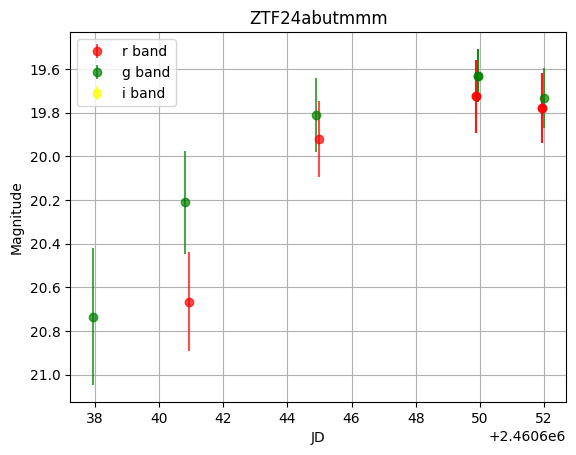

In [10]:
random_object = objects[np.random.randint(len(objects))]

# plot the light curve of the first object
plot_light_curve(random_object['prv_candidates'], obj_id=random_object['_id'])

##### `cross_matches`:
It is a list of matches with other catalogs, in this testing instance created for the summer school, we simply matched with the [NED](https://ned.ipac.caltech.edu/) catalog, which is a catalog of known astronomical objects, mainly of galaxies. We use these matches for a number of experiments in ZTF, such as `CATS150` which focuses on classifying all transients that are hosted in galaxies at less than 150 Mpc from Earth. This is a very useful catalog to have, as it allows us to quickly identify the host galaxy of a transient, and use that information to classify the transient. Let's look at the cross-match data for a random object that matched with NED.

In [11]:
objects_with_ned = [obj for obj in objects if len(obj.get('cross_matches', {}).get('NED', [])) > 0]
random_object_with_ned = objects_with_ned[np.random.randint(len(objects_with_ned))]

# plot the NED cross-match data for the random object
for match in random_object_with_ned['cross_matches'].get('NED', []):
    print(f"-  {match['objname']}; z = {match.get('z', 'unknown')}; separation = {match.get('distance_arcsec', 'unknown')} arcsec")

# check how many have matches with the NED catalog
with_ned = [obj for obj in objects if obj["cross_matches"].get("NED", [])]
print(f"\nFound {len(with_ned)} objects with NED cross-matches")

-  KUG 1301+290; z = 0.02641800045967102; separation = 17.62622801841916 arcsec

Found 394 objects with NED cross-matches


##### `aliases`:
Similarly, it is a list of matches with other catalogs, whoever here the crossmatches are made with other survey catalogs, and we only store the matching object IDs. This is useful to quickly know if a transient has been detected by multiple surveys, and use the object ID to retrieve the other surveys data. Let's look at the aliases for a random object that matched with an LSST objects.

In [12]:
objects_with_lsst = [obj for obj in objects if len(obj.get('aliases', {}).get('LSST', [])) > 0]
random_object_with_lsst = objects_with_lsst[np.random.randint(len(objects_with_lsst))]

print(f"Random object {random_object_with_lsst['_id']} matched with the LSST object {random_object_with_lsst['aliases']['LSST'][0]}")


# Check how many have a match with LSST alerts
with_lsst = [obj for obj in objects if obj["aliases"].get("LSST", [])]
print(f"Found {len(with_lsst)} objects with LSST cross-matches")

Random object ZTF24abrgpqk matched with the LSST object 648374722634973207
Found 1 objects with LSST cross-matches


Let's take advantage of this information and plot the object(s) lightcurve, the LSST counterpart(s) lightcurve (that we need to query too), and the 2 of them together.

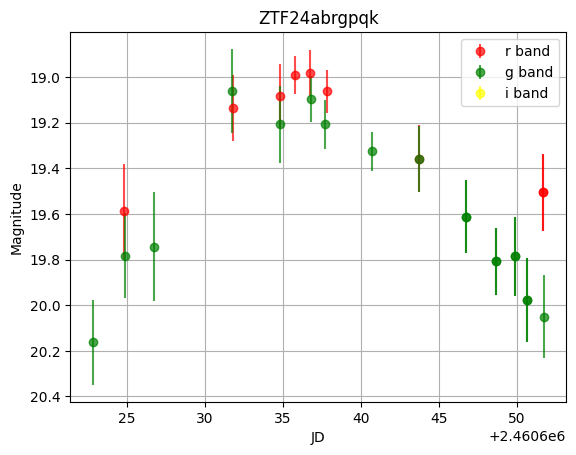

In [13]:
# let's look at the object(s) with the LSST match
obj = with_lsst[0]  # just take the first one for simplicity
plot_light_curve(obj['prv_candidates'], obj_id=obj['_id'])  # ZTF light curve


In [14]:
# let's grab the LSST detections for that object
lsst_data = api.find(
    'LSST_alerts_aux',
    query={
        "_id": obj['aliases']["LSST"][0],
    },
    projection={
        "_id": 1,
        "objectId": 1,
        "prv_candidates": 1,
    }
)

In [15]:
lsst_prv_candidates = lsst_data[0]['prv_candidates'] if lsst_data else []
print(f"Found {len(lsst_prv_candidates)} LSST previous candidates for ZTF object {obj['_id']} with LSST alias {obj['aliases']['LSST'][0]}")

Found 19 LSST previous candidates for ZTF object ZTF24abrgpqk with LSST alias 648374722634973207


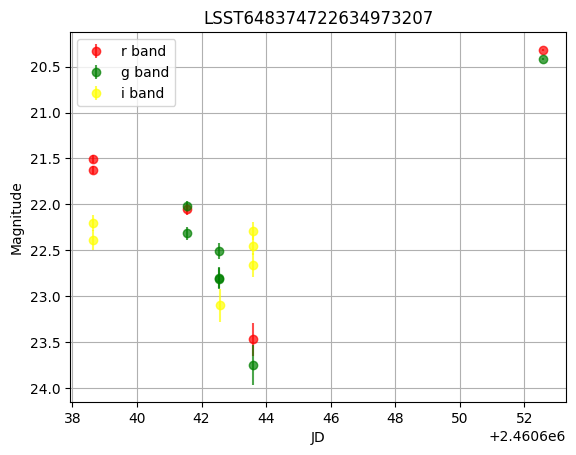

In [16]:
plot_light_curve(lsst_prv_candidates, obj_id=f"LSST{lsst_data[0]['_id']}")

As we can see on the X axis, these objects were detected around the same time by both surveys, nice! Let's try to plot them together:

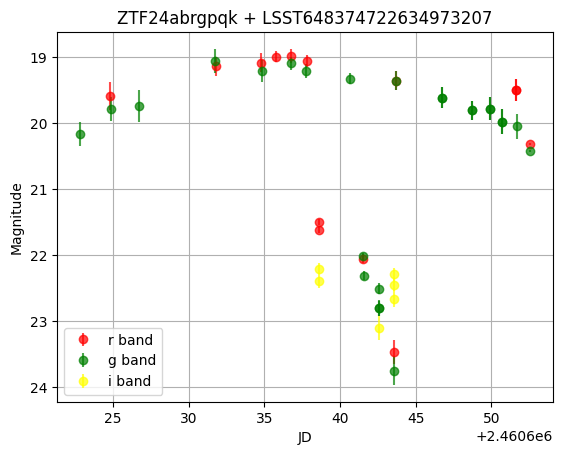

In [17]:
# print both ZTF and LSST light curves together
plot_light_curve(obj["prv_candidates"] + lsst_prv_candidates, obj_id=f"{obj['_id']} + LSST{lsst_data[0]['_id']}")

Hmmmm, that doesn't look quite right! The LSST r and g-band data clearly does not agree with ZTF! Unfortunately, this is a known issue with LSST Data Preview 1 data. The image difference - unlike ZTF - is using reference images that are pretty much as recent as the new images, therefore a number of real transients are already in the reference image(s)! This means that the subtraction image (new - ref) gives us less flux than ZTFs (where there is nothing in the reference, so the flux of the subtraction is all the flux of the transient, unlike LSST where it's only the flux added since the reference was taken).

A quick and dirty fix is to ignore the lsst image difference data, and look at the science flux data, which is the total flux measured in the new image, without any subtraction. If we make the assumption that we are looking at the brand new transient and that we do not have a star underneath it, we can use that in place of the image difference data. Let's try that:

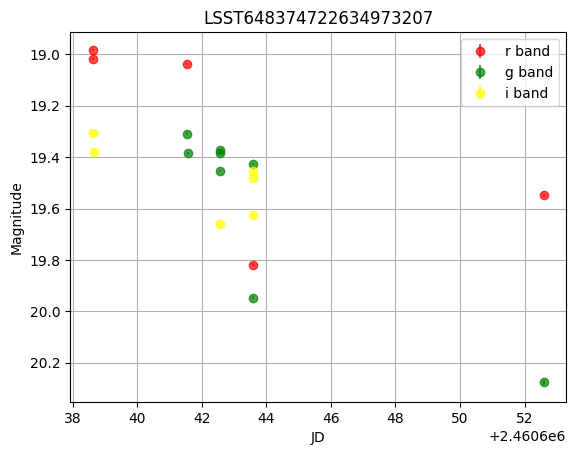

In [18]:
# plot the magsci instead
plot_light_curve(lsst_prv_candidates, magfield='magsci', sigfield='sigmasci', diffmaglim_field='diffmaglim', obj_id=f"LSST{lsst_data[0]['_id']}")

Clearly, this is better. The Y-axis range matches that of ZTF, so let's replace the magpsf data by the magsci data in the LSST lightcurve, and plot it alongside ZTF's:

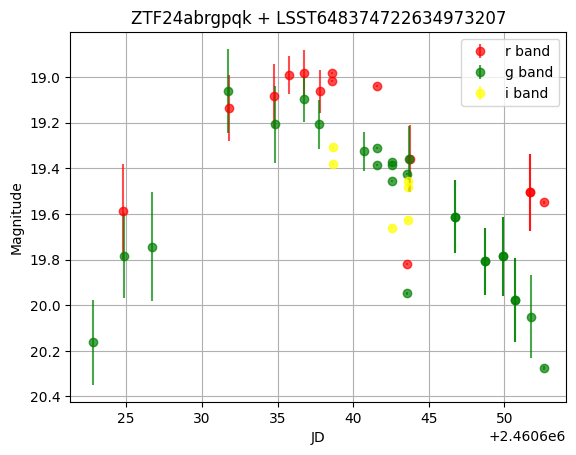

In [19]:
# ok so that's more consistent with ZTF maybe, so let's plot these together
# for that let's simply make a new lsst_prv_candidates where we replace magpsf with magsci
lsst_prv_candidates_sci = [{
    **d,
    'magpsf': d['magsci'],
    'sigmapsf': d['sigmasci'],
} for d in lsst_prv_candidates]

# and plot them together
plot_light_curve(obj["prv_candidates"] + lsst_prv_candidates_sci, obj_id=f"{obj['_id']} + LSST{lsst_data[0]['_id']}")

Hurray! This doesn't look too bad. It's not perfect at all, but enough to visually inspect both lightcurves, until we get some new and improved LSST data.

---
Now, let's query the ZTF alert cutout catalog to retrieve images for the alerts of that object, so we can see what the object looks like in the sky.

In [20]:
# let's look at the images of the alerts we have in the DB
cutouts = api.find(
    'ZTF_alerts_cutouts',
    query={
        "_id": {"$in": [cand["candid"] for cand in obj['prv_candidates']]},
    }
)

print(f"Found cutouts for {len(cutouts)} alerts of object {obj['_id']}")

Found cutouts for 6 alerts of object ZTF24abrgpqk


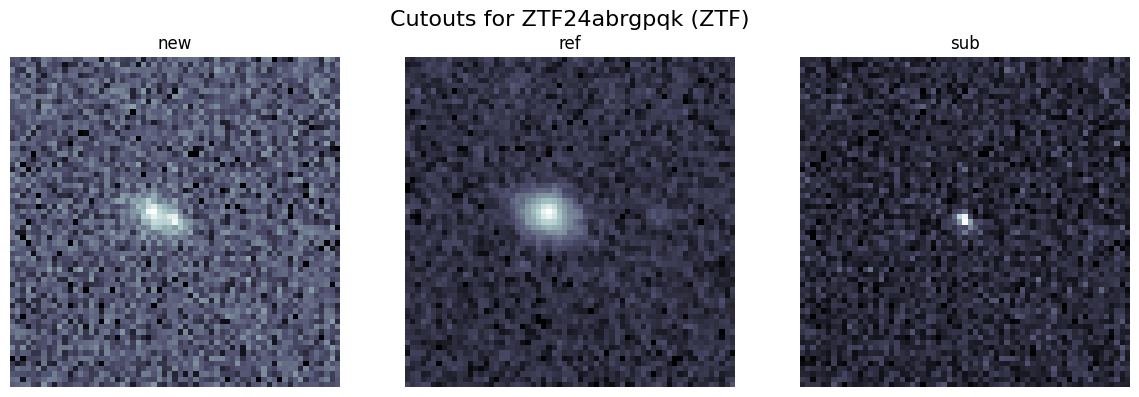

In [21]:

cutouts = cutouts[0]  # assuming we only have one entry per object
plot_cutouts(obj['_id'], cutouts, survey="ZTF")

#### Building a pipeline (Exercise):

Here we are exploring data in a notebook, manually, way after the alerts were generated, and looking at only a week. However, we often want to run pipeline on the full survey or in real-time as new alerts come in. In that case, you'll want to automate the process of querying candidates, filtering through them, and identifying those you care about.

Let's build a pipeline to look at "fast" transients, which for the sake of that exercise we'll define as transients that are:
- rising in brightness more than 0.3 mag in 1 day
- getting dimmer (fading) more than 0.5 mag in 1 day

To do that, we want to:
- provided a query, find alerts of interest
- query lightcurves for all the unique objects we found
- for each ZTF filter/band we saw an object in, find the peak magnitude
- split the lightcurves into rising and fading parts (before and after the peak magnitude)
- measure the magnitude rate (mag per day) for each part, with a simple linear fit
- see if the rising rate is above 0.3 mag/day and the fading rate is below -0.5 mag/day

For reference, this is heavily inspired by **ZTFReST**, a pipeline and program that looks for fast evolving transients in the ZTF alert stream, and has been doing so for a few years now. You can find the paper [here](https://arxiv.org/abs/2104.06352) (*Not so much of a hint, but obviously you can use that as an inspiration*).

Here are some notes about problems you can expect to encounter:
- A fit requires at least 2 points, so if you have only one point in a filter and part, you can't fit it.
- Magnitude data is often noisy, and has associated error bars. So even if you have say 2 points with some magnitude difference between them, if they error bars are large enough, the difference - when encounting for the errors - might not be significant enough to be considered a rise or a fade.

**In the cell below, you'll find some of the logic already implemented, and you'll have to fill in the gaps. You are also encouraged to add more logic to handle edge cases, and to customize the initial query to find different types of objects you care about.**

In [22]:

def rapid_rise_fade_pipeline(query, rise_threshold=0.3, fade_threshold=0.5):
    # Step 1: Find ZTF alerts
    alerts = api.find(
        'ZTF_alerts',
        query=query,
        projection={
            "_id": 1,
            "objectId": 1,
            "candidate": 1,
            "classifications": 1,
        }
    )
    
    print(f"Found {len(alerts)} alerts")

    # Step 2: Retrieve objects with LSST cross-matches
    object_ids = {alert['objectId'] for alert in alerts if 'objectId' in alert}
    print(f"Found {len(object_ids)} unique object IDs")

    objects = api.find(
        'ZTF_alerts_aux',
        query={"_id": {"$in": list(object_ids)}},
        projection={
            "_id": 1,
            "aliases": 1,
            "prv_candidates": 1,
        }
    )
    assert len(objects) == len(object_ids), "Not all object IDs found in ZTF_alerts_aux"

    selected_object_ids = []

    for obj in tqdm(objects, desc="Processing objects"):
        # TODO: find all unique bands we have data for
        all_bands = ... # TODO: find all unique bands we have data for

        for band in all_bands:
            # TODO: find the peak magnitude in this band (lowest mag)
            photometry = ...

            # sort by jd ascending
            photometry.sort(key=lambda x: x['jd'])

            # TODO: find the index of the peak magnitude
            peak_idx = ...
            
            # TODO:
            # - get the photometry BEFORE peak, handle edge cases like missing data
            #   noisy data (not significant difference between min and max mag)
            # - fit with numpy's polyfit, see if the measured slope is above the RISE threshold
            pre_peak_photometry = photometry[:peak_idx]
            ...
            rise_rate = ...  # calculate the rise rate from pre_peak_photometry
            if rise_rate > rise_threshold:
                selected_object_ids.append(obj['_id'])
                print(f"Object {obj['_id']} has a rapid rise in band {band} with rate {rise_rate:.2f}")
                break
            

            # TODO:
            # - get the photometry AFTER peak, handle edge cases like missing data
            #   noisy data (not significant difference between min and max mag)
            # - fit with numpy's polyfit, see if the measured slope is above the FADE threshold
            pre_peak_photometry = photometry[:peak_idx]
            ...
            fade_rate = ...  # calculate the fade rate from post_peak_photometry
            if fade_rate > fade_threshold:
                selected_object_ids.append(obj['_id'])
                print(f"Object {obj['_id']} has a rapid fade in band {band} with rate {fade_rate:.2f}")
                break

    print(f"Selected {len(selected_object_ids)} objects with rapid rise or fade")
    return selected_object_ids

# test it on the first query we used
rapid_rise_fade_query = {
    "candidate.drb": {"$gt": 0.8},
    "candidate.ndethist": {"$lt": 50, "$gte": 2},
    "candidate.isdiffpos": True,
    "candidate.ssdistnr": {"$lt": 0},
    "candidate.nbad": { "$lt": 5 },
    "candidate.fwhm": { "$gt": 0.5, "$lt": 8 }, 
    "$and": [
        { "$or": [
            {"candidate.sgscore1": {"$lt": 0.7}},
            {"candidate.distpsnr1": {"$gt": 2.0}},
            {"candidate.distpsnr1": {"$lt": 0}},
        ]},
        {
            "$or": [
                {"classifications.acai_h": {"$gte": 0.8}},
                {"classifications.acai_o": {"$gte": 0.8}},
            ]
        }
    ]
}
obj_ids = rapid_rise_fade_pipeline(rapid_rise_fade_query)

print(f"Found {len(obj_ids)} objects with rapid rise or fade")

Found 2544 alerts
Found 1316 unique object IDs


Processing objects:   0%|          | 0/1316 [00:00<?, ?it/s]


TypeError: 'ellipsis' object is not iterable

Now that you've identified some transients, you'll want to visualize them. To make it as easy as possible, let's write a function that takes a ZTF object ID and plots the cutouts + lightcurve of the object.

In [ ]:
# TODO: write a function to plot the cutouts and light curves for a given ZTF object ID
def plot_ztf_object(obj_id):
    # Step 1: Retrieve the object
    obj = api.find(
        'ZTF_alerts_aux',
        query={"_id": obj_id},
        projection={
            "_id": 1,
            "aliases": 1,
            "prv_candidates": 1,
        }
    )
    
    if not obj:
        print(f"No object found with ID {obj_id}")
        return
    
    obj = obj[0]

    # Retrieve the cutouts
    cutouts = api.find(
        'ZTF_alerts_cutouts',
        query={
            "_id": {"$in": [cand["candid"] for cand in obj['prv_candidates']]},
        }
    )
    
    # TODO: create a composite plot (with subplots) with cutouts and light curve
    ...

In [ ]:
# plot the objects identified by the rapid rise/fade pipeline, for some manual visual inspection.
for obj in obj_ids:
    plot_ztf_object(obj)